# Projet Science des données Marty Vincent

N° étudiant : 21704218

## Introduction

Bonjour, dans ce notebook, nous allons examiner deux ensembles de données. Le premier concerne les risques d'AVC, où nous effectuerons une analyse exploratoire et utiliserons une régression logistique pour créer un modèle prédictif. Le deuxième concerne les clients d'un supermarché, où nous appliquerons la méthode Kmean et la compléterons avec une analyse en composantes principales (ACP).

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
from pandas.plotting import scatter_matrix
import seaborn as sns
plt.rcParams['figure.figsize'] = (12, 8)
sns.set()
sns.set(font_scale=1.5)

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

pd.set_option('display.max_columns', 100)
pd.set_option('expand_frame_repr', True)

In [2]:
filename = 'healthcare-dataset-stroke-data.csv'
df = pd.read_csv(filename)

## Analyse Exploratoire

Commençons par regarder ce avec quoi nous travaillons.

In [3]:
df.head(10)

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1
5,56669,Male,81.0,0,0,Yes,Private,Urban,186.21,29.0,formerly smoked,1
6,53882,Male,74.0,1,1,Yes,Private,Rural,70.09,27.4,never smoked,1
7,10434,Female,69.0,0,0,No,Private,Urban,94.39,22.8,never smoked,1
8,27419,Female,59.0,0,0,Yes,Private,Rural,76.15,NaN,Unknown,1
9,60491,Female,78.0,0,0,Yes,Private,Urban,58.57,24.2,Unknown,1


In [4]:
df.describe()

,id,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,5110.000000,5110.000000,5110.000000,5110.000000,5110.000000,4909.000000,5110.000000
mean,36517.829354,43.226614,0.097456,0.054012,106.147677,28.893237,0.048728
std,21161.721625,22.612647,0.296607,0.226063,45.283560,7.854067,0.215320
min,67.000000,0.080000,0.000000,0.000000,55.120000,10.300000,0.000000
25%,17741.250000,25.000000,0.000000,0.000000,77.245000,23.500000,0.000000
50%,36932.000000,45.000000,0.000000,0.000000,91.885000,28.100000,0.000000
75%,54682.000000,61.000000,0.000000,0.000000,114.090000,33.100000,0.000000
max,72940.000000,82.000000,1.000000,1.000000,271.740000,97.600000,1.000000


In [5]:
print(f'There are {df.shape[0]} observations and {df.shape[1]} features')

There are 5110 observations and 12 features


In [6]:
for i in df.columns.tolist():
    print('le type de la colonne',i ,' est:',df[i].dtype)

le type de la colonne id  est: int64
le type de la colonne gender  est: object
le type de la colonne age  est: float64
le type de la colonne hypertension  est: int64
le type de la colonne heart_disease  est: int64
le type de la colonne ever_married  est: object
le type de la colonne work_type  est: object
le type de la colonne Residence_type  est: object
le type de la colonne avg_glucose_level  est: float64
le type de la colonne bmi  est: float64
le type de la colonne smoking_status  est: object
le type de la colonne stroke  est: int64


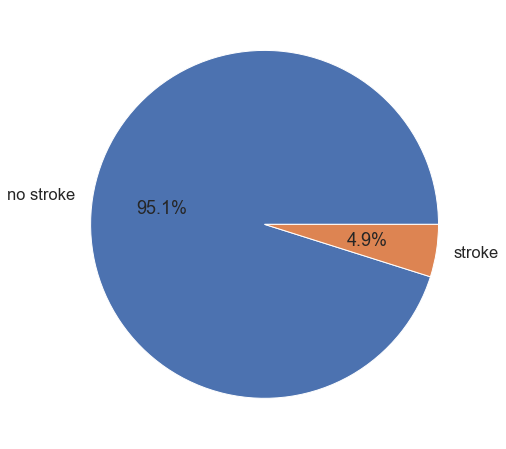

In [7]:
plt.pie(df['stroke'].value_counts(), labels = ['no stroke','stroke'], autopct='%1.1f%%');

$\textbf{Remarque}$

Il semble y avoir un déséquilibre dans nos données, ce qui peut avoir un impact sur la performance de notre modèle.

#### Analyse des données manquantes dans chaque colonne:

In [8]:
def num_missing(x):
    return sum(x.isnull())

print("Valeurs manquantes par colonne:")

print(df.apply(num_missing, axis=0).where(lambda x : x != 0).dropna())

Valeurs manquantes par colonne:
bmi    201.0
dtype: float64


Il manque 201 valeurs dans la colonne BMI, pour savoir ce que nous pouvons faire de ces données manquantes, regardons si il y a un biais.

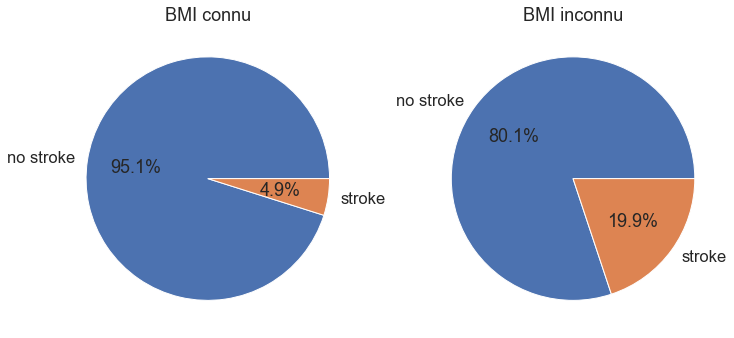

In [9]:
plt.subplot(1,2,1)
plt.pie(df['stroke'].value_counts(), labels = ['no stroke','stroke'], autopct='%1.1f%%')
plt.title('BMI connu');
plt.subplot(1,2,2)
plt.pie(df['stroke'].where(df['bmi'].isnull()).value_counts(), labels = ['no stroke','stroke'], autopct='%1.1f%%');
plt.title('BMI inconnu');

Il y a un clair déséquilibre entre les deux graphiques, on peut donc estimer que les données manquantes sont biaisés. On va remplacer les données manquantes par la moyenne de la colonne 'BMI'.

In [10]:
df['bmi'] = df['bmi'].fillna(df['bmi'].mean())

In [11]:
print(df.apply(num_missing, axis=0).where(lambda x : x != 0).dropna())

Series([], dtype: float64)


Les valeurs manquantes ont bien été remplacés.

On enlève les colonnes où chacune des valeurs sont uniques.

In [12]:
for col in df.columns:
    if df[col].unique().size==df.shape[0]:
        print("Dropping column: {0}".format(col))
        df = df.drop(col, axis=1)

Dropping column: id


---

### Etudes des données numériques

Nous allons ici regarder la distributions des différentes variables numériques, c'est à dire : 'age', 'bmi' et 'avg_glucose_level'.

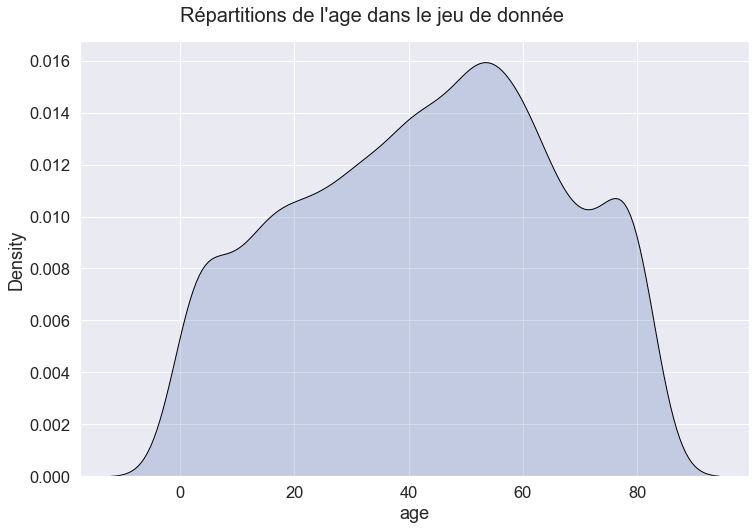

In [13]:
sns.kdeplot(df['age'],shade = True,edgecolor='black').text(0,0.0175,"Répartitions de l'age dans le jeu de donnée",size = 20);

On note qu'une grande partie des personnes dans ce jeu de donnée on entre 40 et 60 ans.

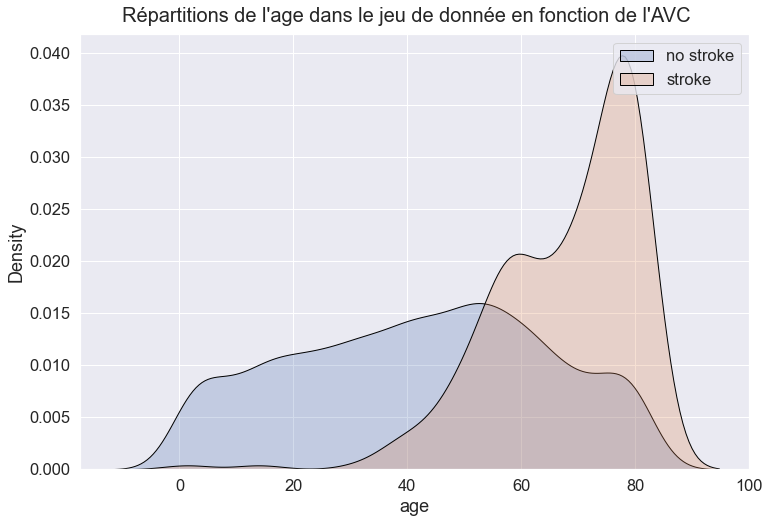

In [14]:
sns.kdeplot(df['age'].where(df['stroke'] == 0),label = 'no stroke',shade = True,edgecolor='black')
sns.kdeplot(df['age'].where(df['stroke'] == 1),label = 'stroke',shade = True,edgecolor='black').text(-10,0.043,"Répartitions de l'age dans le jeu de donnée en fonction de l'AVC",size = 20);
plt.legend();

L'age semble être une variable importante pour expliquer le risque d'AVC.

---

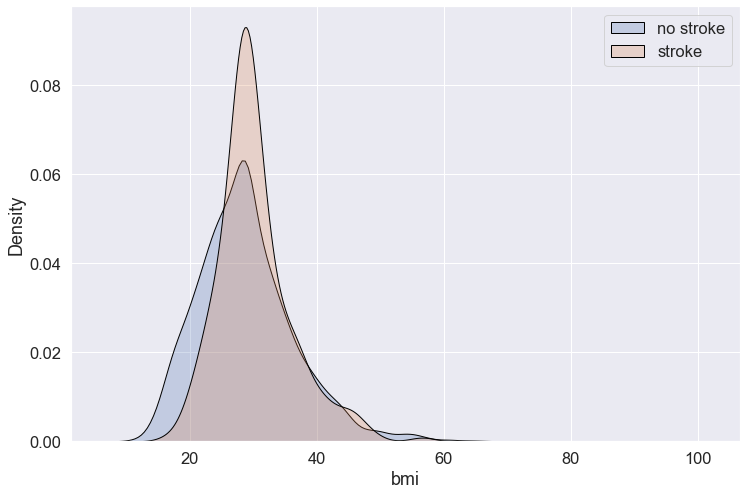

In [15]:
sns.kdeplot(df['bmi'].where(df['stroke'] == 0),label = 'no stroke',shade = True,edgecolor='black');
sns.kdeplot(df['bmi'].where(df['stroke'] == 1),label = 'stroke',shade = True,edgecolor='black');
plt.legend();

Il semble que la colonne 'bmi' explique peu le risque d'AVC, cela pourrait être dû à des données manquantes.

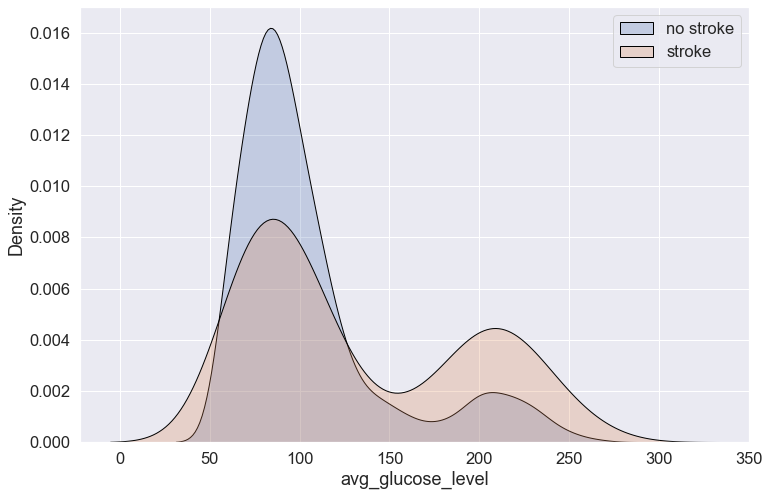

In [16]:
sns.kdeplot(df['avg_glucose_level'].where(df['stroke'] == 0),label = 'no stroke',shade = True,edgecolor='black');
sns.kdeplot(df['avg_glucose_level'].where(df['stroke'] == 1),label = 'stroke',shade = True,edgecolor='black');
plt.legend();

Il semble que les personnes ayant un niveau de glucose plus élevé ont un plus grand risque d'AVC.

### Analyse des variables catégorielles

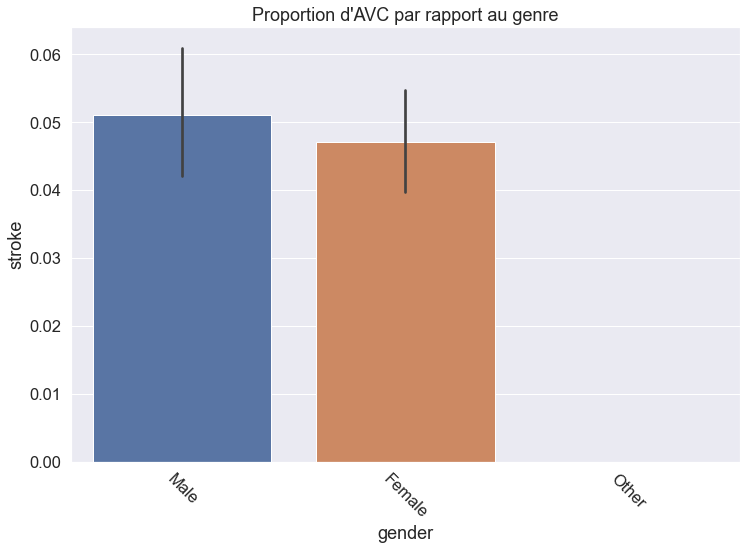

In [17]:
p = sns.barplot(x='gender',y = 'stroke',data = df, estimator = np.mean);
p.set(title="Proportion d'AVC par rapport au genre")
p.set_xticklabels(p.get_xticklabels(), rotation=-45);

La variable 'gender' semble avoir peu d'effet sur le risque d'AVC.

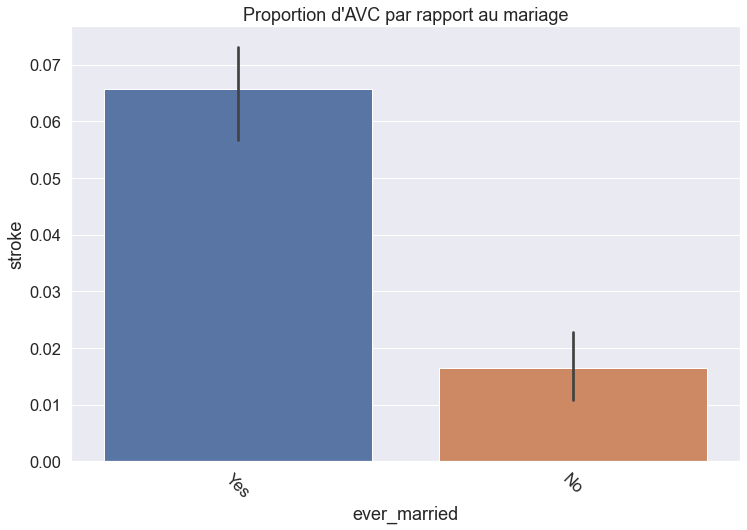

In [18]:
p = sns.barplot(x='ever_married',y = 'stroke',data = df, estimator = np.mean);
p.set(title="Proportion d'AVC par rapport au mariage")
p.set_xticklabels(p.get_xticklabels(), rotation=-45);

La variable 'ever_married' semble avoir beaucoup d'effet sur le risque d'AVC

[Text(0.5, 1.0, "Proportion d'AVC par rapport à la présence de maladie au coeur")]

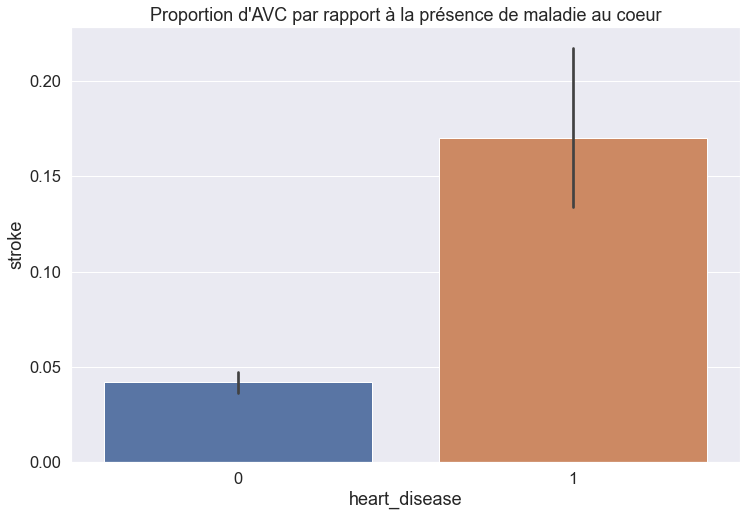

In [19]:
p = sns.barplot(x='heart_disease',y = 'stroke',data = df, estimator = np.mean);
p.set(title="Proportion d'AVC par rapport à la présence de maladie au coeur")

La variable 'heart_disease' semble avoir beaucoup d'effet sur le risque d'AVC.

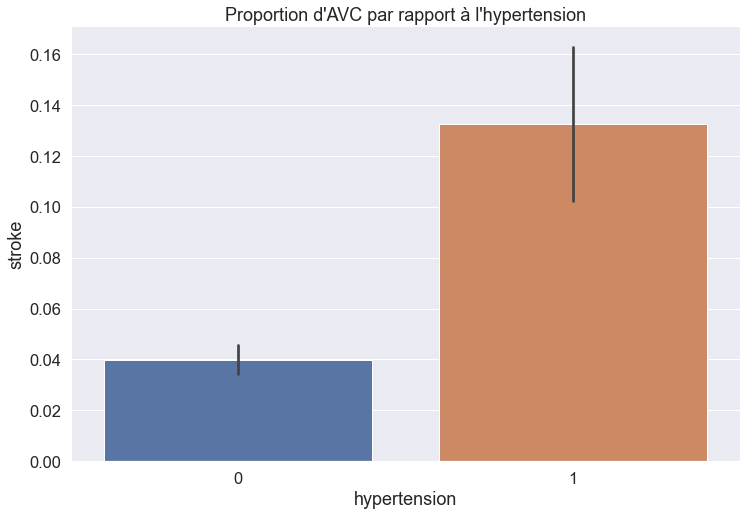

In [20]:
p = sns.barplot(x='hypertension',y = 'stroke',data = df, estimator = np.mean);
p.set(title="Proportion d'AVC par rapport à l'hypertension");

La variable 'hypertension' semble avoir beaucoup d'effet sur le risque d'AVC.

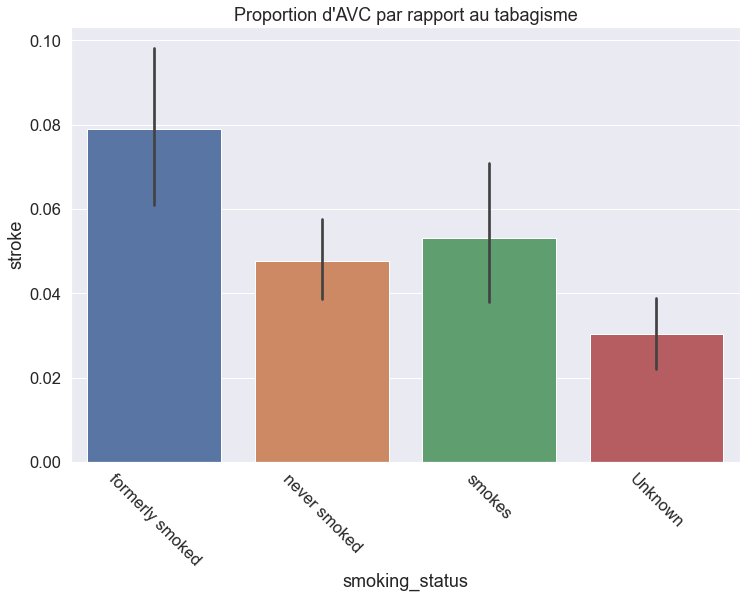

In [21]:
p = sns.barplot(x='smoking_status',y = 'stroke',data = df, estimator = np.mean);
p.set(title="Proportion d'AVC par rapport au tabagisme");
p.set_xticklabels(p.get_xticklabels(), rotation=-45);

Les personnes qui fume ou qui ont fumé semble être les plus à risque d'AVC.

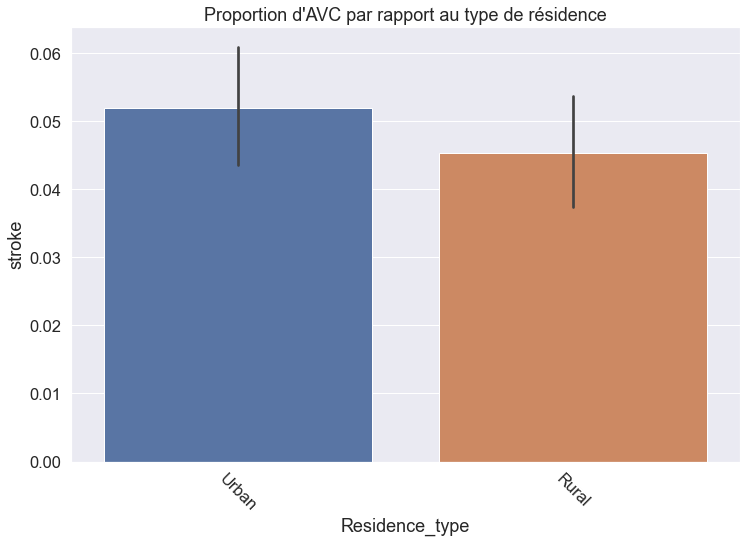

In [22]:
p = sns.barplot(x='Residence_type',y = 'stroke',data = df, estimator = np.mean);
p.set(title="Proportion d'AVC par rapport au type de résidence");
p.set_xticklabels(p.get_xticklabels(), rotation=-45);

La variable 'Residence_type' semble avoir peu d'effet sur le risque d'AVC.

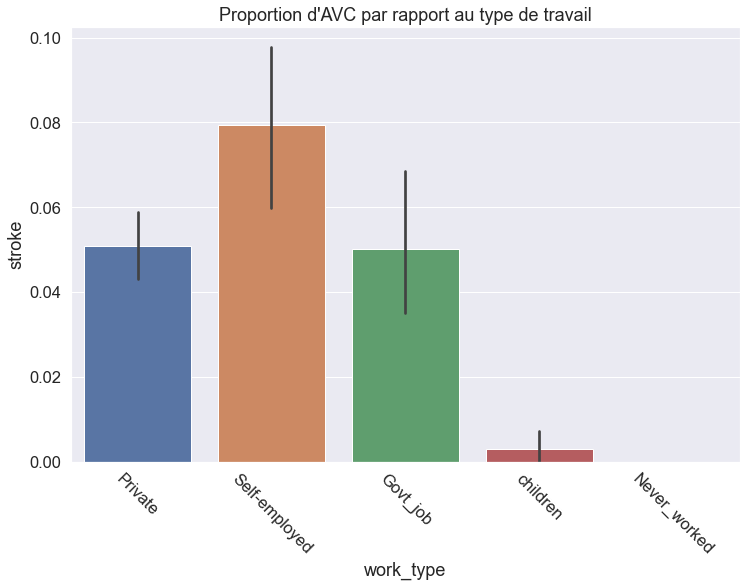

In [23]:
p = sns.barplot(x='work_type',y = 'stroke',data = df, estimator = np.mean);
p.set(title="Proportion d'AVC par rapport au type de travail");
p.set_xticklabels(p.get_xticklabels(), rotation=-45);

Les indépendants semble les plus touché par les risques d'AVC, il faut faire attention toutefois on peut remarquer la présence de la variable 'children' ce qui peut indiquer une certaines corrélation avec la variable 'age'.

## Apprentissage supervisé

On souhaite prédire la possibilité qu'une personne est un AVC. La colonne AVC est binaire donc pour créer un modèle d'apprentissage, on va utiliser un modèle de régression logistique. (Une explication plus détaillé [sur cette vidéo](https://www.youtube.com/watch?v=yIYKR4sgzI8))

Pour utiliser un modèle multivarié il faut d'abord vérifier la corrélation entre chaque variable pour éviter tout problème de multicolinéarité. On va utiliser la fonction heatmap de seaborn pour le visualiser, mais avant tout il faut encoder les variables catégorielles et normaliser les variables numériques.

In [24]:
from scipy import stats as stats
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import statsmodels.api as sm
from sklearn.metrics import roc_curve, auc, accuracy_score, confusion_matrix, recall_score, precision_score, roc_auc_score, f1_score

In [25]:
df_copy = df.copy()
for col in df_copy.columns.tolist():
    if df_copy[col].dtype=='object':
        #On encode les variables catégorielles à l'aide de LabelEncoder
        df_copy[col] = preprocessing.LabelEncoder().fit_transform(df_copy[col])


Z = ['age','bmi','avg_glucose_level']
#On normalise les variables numériques 'age', 'bmi' et 'avg_glucose_level'
df_copy[Z] = preprocessing.MinMaxScaler().fit_transform(df_copy[Z])
df_copy.head(10)

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,1,0.816895,0,1,1,2,1,0.801265,0.301260,1,1
1,0,0.743652,0,0,1,3,0,0.679023,0.212981,2,1
2,1,0.975586,0,1,1,2,0,0.234512,0.254296,2,1
3,0,0.597168,0,0,1,2,1,0.536008,0.276060,3,1
4,0,0.963379,1,0,1,3,0,0.549349,0.156930,2,1
5,1,0.987793,0,0,1,2,1,0.605161,0.214204,1,1
6,1,0.902344,1,1,1,2,0,0.069107,0.195876,2,1
7,0,0.841309,0,0,0,2,1,0.181285,0.143184,2,1
8,0,0.719238,0,0,1,2,0,0.097082,0.212981,0,1
9,0,0.951172,0,0,1,2,1,0.015927,0.159221,0,1


Les variables catégorielles ont bien été encodées et les variables numériques ont bien été normalisées.

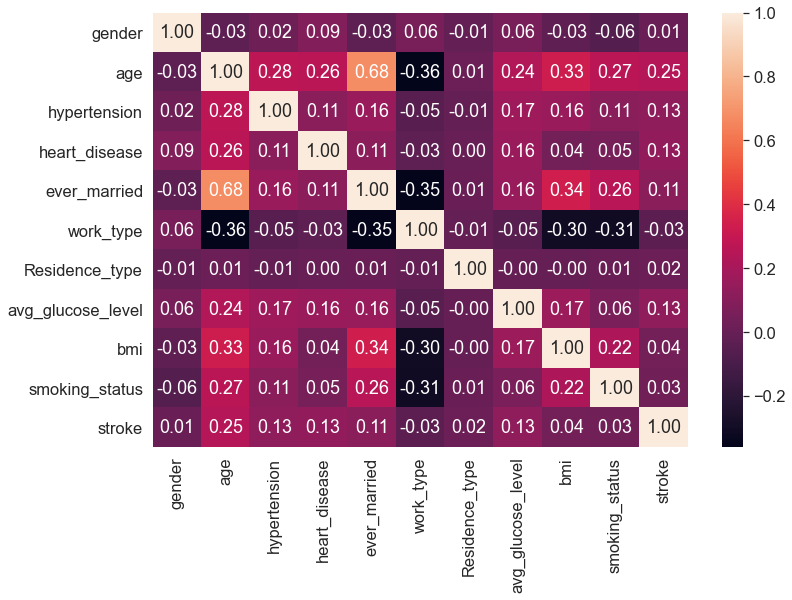

In [26]:
sns.heatmap(df_copy.corr(),annot = True,fmt=".2f");

On peut faire plusieurs observation:
- 'age' est bien la variable la plus importante pour prédire le risque d'AVC.
- 'ever_married' qui semblait être une variable importante pour prédire le risque d'AVC est aussi corrélée avec la variable 'age', donc nous ne l'utiliserons pas.
- 'heart_disease', 'hypertension' et 'avg_glucose_level' semble avoir une importance significative pour prédire le risque d'AVC.
- Le reste des variables ne semble pas avoir une importance suffisantes pour prédire le risque d'AVC.

$\textbf{Conclusion :}$

On utilisera pour notre modèle de régression logistique la colonne 'age', 'heart_disease', 'hypertension' et 'avg_glucose_level'

In [27]:
pd.options.mode.chained_assignment = None  # default='warn'

# Define our dependent variable
y_column = 'stroke'
y = df_copy[y_column]

# Define our independent variables
# After testing, it appears that heart_disease lower the performance of our model, so we will not use it.
x_columns = ['age','hypertension','avg_glucose_level']
X = df_copy[x_columns]

# Add an intercept term to the independent variables. This is needed in order to include the constant term from
# logistic regression equation.
X['intercept'] = 1

# Split our data into training and test data sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=16)

In [28]:
logistic_regression = LogisticRegression()
logistic_regression.fit(X_train, y_train)
y_pred = logistic_regression.predict(X_test)

LogisticRegression()

Notre modèle c'est bien entrainé sur les valeurs d'entrainement, nous allons regardé à présent son efficacité sur les valeur de test. Pour cela on va utilisé de façon de comparer les résultat:
- Précision: La précision mesure la capacité du modèle à prédire correctement les cas positifs.
- TPR: Le TPR (Taux de vrais positifs) mesure la proportion de cas positifs réels qui sont correctement prédits par le modèle.
- F1 Score: Il s'agit d'un indicateur de performance qui combine la précision et le TPR en utilisant une moyenne pondérée. Il peut être utile lorsque la distribution des classes est déséquilibrée.
- Exactitude: L'exactitude mesure la proportion de prédictions correctes par rapport au nombre total de prédictions.
- L'AUC-ROC: Aire sous la courbe ROC mesure la performance du modèle en comparant les scores prédits aux valeurs réelles. Si le score est de 0.5, alors notre modèle est aussi efficace qu'un modèle aléatoire. On souhaite que notre score soit le plus proche de 1. On peut trouver une explication plus détaillé [ici](https://developers.google.com/machine-learning/crash-course/classification/roc-and-auc?hl=fr).
- La matrice de confusion, Il s'agit d'un tableau qui montre le nombre de vrais positifs, de faux positifs, de vrais négatifs et de faux négatifs. 

In [29]:
accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)
tpr = recall_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
print("F1 score: ", f1)
print("Précision: {:.3f}".format(precision))
print("TPR: {:.3f}".format(tpr))
print("Exactitude: {:.3f}".format(accuracy))
print("AUC-ROC: {:.3f}".format(roc_auc))

F1 score:  0.0
Précision: 0.000
TPR: 0.000
Exactitude: 0.949
AUC-ROC: 0.500


C:\Users\vince\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


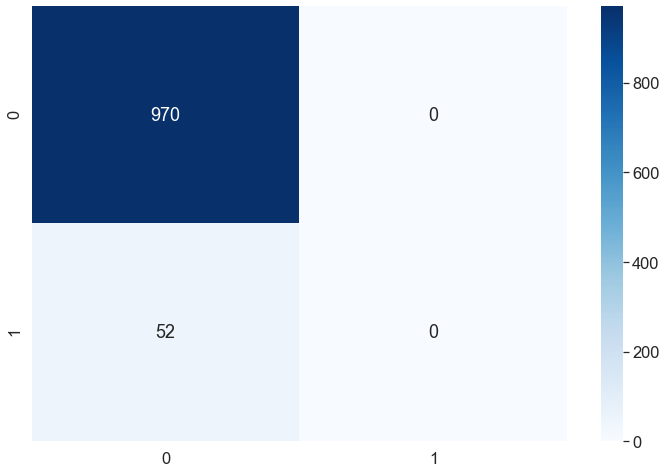

In [30]:
confusion_mat = confusion_matrix(y_test, y_pred)
sns.heatmap(confusion_mat, annot=True, fmt='d', cmap='Blues');

Nous avons un déséquilibre dans nos données entre 'stroke' et 'no stroke', ce qui empêche notre modèle de s'entraîner correctement. Pour corriger ce problème, nous utiliserons la technique d'oversampling SMOTE de la librairie imblearn (un article plus détaillé [ici](https://machinelearningmastery.com/smote-oversampling-for-imbalanced-classification/)). Notez que cette librairie doit être installée manuellement via le terminal.
- Pour anaconda : conda install -c conda-forge imbalanced-learn
- Pour PyPi : pip install -U imbalanced-learn

In [31]:
from imblearn.over_sampling import SMOTE
X_train_smo, y_train_smo = SMOTE().fit_resample(X_train, y_train.ravel())

In [32]:
logistic_regression = LogisticRegression()
logistic_regression.fit(X_train_smo, y_train_smo)
y_pred = logistic_regression.predict(X_test)

LogisticRegression()

F1 score: 0.254
Précision: 0.149
TPR: 0.865
Exactitude: 0.741
AUC-ROC: 0.800


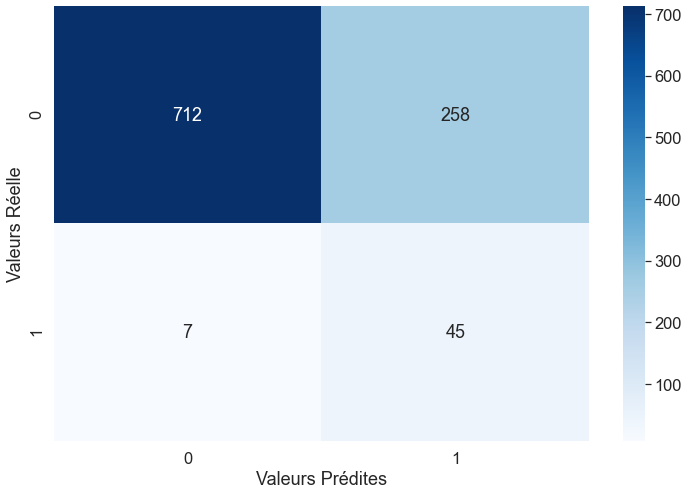

In [33]:
accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)
tpr = recall_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
print("F1 score: {:.3f}".format(f1))
print("Précision: {:.3f}".format(precision))
print("TPR: {:.3f}".format(tpr))
print("Exactitude: {:.3f}".format(accuracy))
print("AUC-ROC: {:.3f}".format(roc_auc))
confusion_mat = confusion_matrix(y_test, y_pred)
sns.heatmap(confusion_mat, annot=True, fmt='d', cmap='Blues');
plt.xlabel('Valeurs Prédites')
plt.ylabel('Valeurs Réelle')
plt.show();

On observe que notre modèle s'est considérablement amélioré, mais n'est pas encore parfait. Le taux de faux négatifs a significativement diminué, ce qui est crucial dans le domaine médical. Cependant, avec un F1 score d'environ 0,25, une exactitude d'environ 0.75 et un AUC-ROC d'environ 0.8 , notre modèle peut être utile mais ne peut pas remplacer un expert. Nous devons effectuer une dernière vérification des données de test pour éviter tout overfitting. Pour cela, nous utiliserons le score de validation croisée et la courbe d'apprentissage.

### Score de validation croisée et courbe d'apprentissage

Le score de validation croisée (cross-validation score) est une méthode utilisée pour évaluer la performance d'un modèle de machine learning sur des données non vues. Il fonctionne en divisant les données en plusieurs parties, en entraînant le modèle sur une partie et en l'évaluant sur une autre partie. Ce processus est répété plusieurs fois avec des parties différentes utilisées à chaque fois pour l'entraînement et l'évaluation. La performance finale du modèle est déterminée par la moyenne des scores obtenus à chaque itération. Cela permet d'obtenir une estimation plus fiable de la performance du modèle sur des données réelles. Cette méthode peut être utile pour détecter les possibilité d'overfitting ou d'underfitting.

In [34]:
from sklearn.model_selection import cross_val_score, learning_curve
scores = cross_val_score(logistic_regression, X_train_smo, y_train_smo, cv=5)
print("Scores de validation croisée:", scores)
print("Moyenne du score de validation croisée:", np.mean(scores))

Scores de validation croisée: [0.74823378 0.76364804 0.75706941 0.77506427 0.76735219]
Moyenne du score de validation croisée: 0.7622735370406144


Avec des scores de validation croisée proches les uns des autres et proche de la moyenne, il semblerait à première vue que notre modèle donne des résultats satisfaisants sans présenter d'overfitting. Nous allons tout de même faire une deuxième vérification avec la courbe d'apprentissage pour être sûre.

La courbe d'apprentissage est un graphique qui montre la relation entre la performance d'un modèle de machine learning et la quantité de données utilisées pour l'entraîner. Plus de détail sur ce graphique sur [ce lien](https://vitalflux.com/learning-curves-explained-python-sklearn-example/).

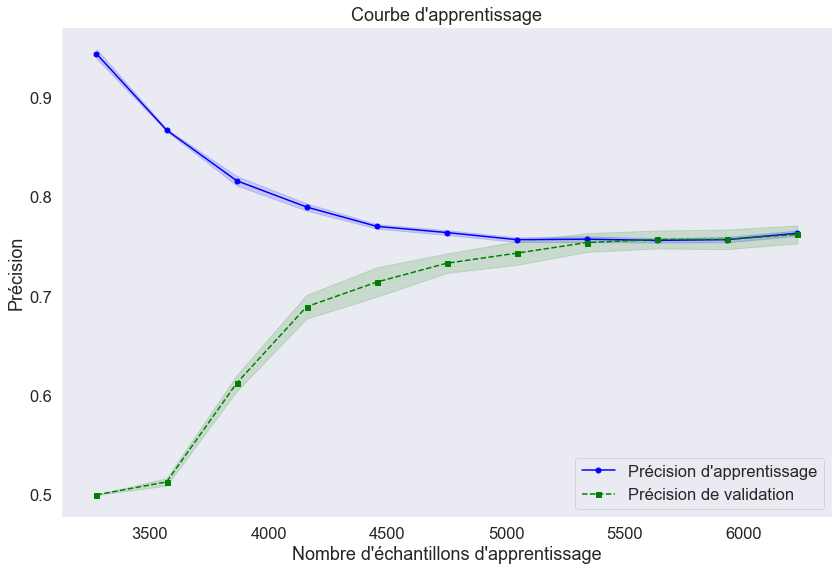

In [35]:
train_sizes, train_scores, test_scores = learning_curve(estimator=logistic_regression,
                                                        X=X_train_smo,
                                                        y=y_train_smo,
                                                        cv=5,
                                                        n_jobs=-1,
                                                        #nombre de point dans la courbe, il vaut mieux mettre un nombre paire
                                                        #puisque ces poitns sont partagés entre les deux courbes.
                                                        train_sizes=np.linspace(0.1, 1.0, 20))

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(train_sizes, train_mean, color='blue', marker='o', markersize=5, label="Précision d'apprentissage")
plt.fill_between(train_sizes, train_mean + train_std, train_mean - train_std, alpha=0.15, color='blue')

plt.plot(train_sizes, test_mean, color='green', linestyle='--', marker='s', markersize=5, label='Précision de validation')
plt.fill_between(train_sizes, test_mean + test_std, test_mean - test_std, alpha=0.15, color='green')

plt.grid()
plt.xlabel("Nombre d'échantillons d'apprentissage")
plt.ylabel('Précision')
plt.legend(loc='lower right')
plt.tight_layout()
plt.title("Courbe d'apprentissage")

plt.show();

Avec cette courbe on peut en conclure que notre modèle possède un bon équilibre entre biais et variance.

### Conclusion

Ce modèle basé sur une régression logistique présente une précision acceptable sans risque d'overfitting, cependant, il peut encore être amélioré pour une utilisation réelle. Pour obtenir un modèle plus performant, il y a plusieurs options à explorer, telles que l'utilisation d'une autre méthode d'apprentissage, comme les forêts aléatoires, ou une meilleure base de données avec un nombre équilibré de cas d'AVC dès le début.

---

## Apprentissage non supervisé

In [36]:
filename = 'Mall_Customers.csv'
df2 = pd.read_csv(filename)
df2

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40
...,...,...,...,...,...
195,196,Female,35,120,79
196,197,Female,45,126,28
197,198,Male,32,126,74
198,199,Male,32,137,18


In [37]:
df2.describe()

,CustomerID,Age,Annual Income (k$),Spending Score (1-100)
count,200.000000,200.000000,200.000000,200.000000
mean,100.500000,38.850000,60.560000,50.200000
std,57.879185,13.969007,26.264721,25.823522
min,1.000000,18.000000,15.000000,1.000000
25%,50.750000,28.750000,41.500000,34.750000
50%,100.500000,36.000000,61.500000,50.000000
75%,150.250000,49.000000,78.000000,73.000000
max,200.000000,70.000000,137.000000,99.000000


In [38]:
print(f'There are {df2.shape[0]} observations and {df2.shape[1]} features')

There are 200 observations and 5 features


In [39]:
print("Valeurs manquantes par colonne:")
print(df2.apply(num_missing, axis=0).where(lambda x : x != 0).dropna())

Valeurs manquantes par colonne:
Series([], dtype: float64)


Aucune donnée manquante, on peut continuer sans problème.

In [40]:
for i in df2.columns.tolist():
    print('le type de la colonne',i ,' est:',df2[i].dtype)

le type de la colonne CustomerID  est: int64
le type de la colonne Gender  est: object
le type de la colonne Age  est: int64
le type de la colonne Annual Income (k$)  est: int64
le type de la colonne Spending Score (1-100)  est: int64


On va enlever la colonne 'CustomerID' qui n'a aucune utilité pour la suite.

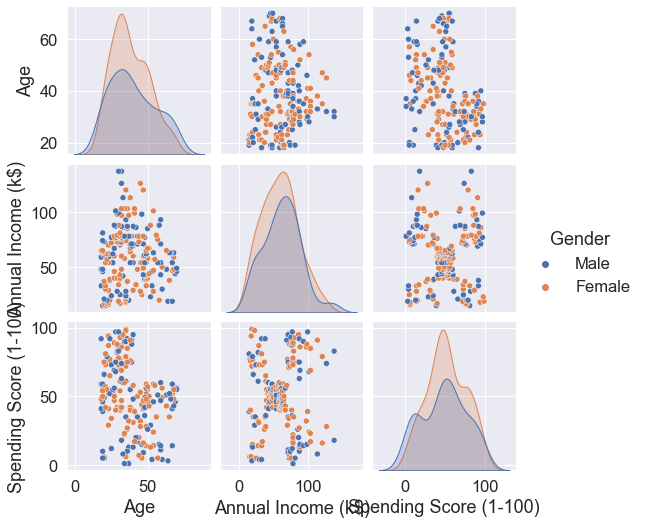

In [41]:
sns.pairplot(df2.drop('CustomerID', axis=1), hue = 'Gender')

Il semble il y a avoir peut de différence en fonction du genre, on va donc supprimé la colonne gender et customerID.

In [42]:
df2_data = df2.drop(['CustomerID','Gender'], axis=1)

In [43]:
from scipy.cluster.hierarchy import linkage
from pylab import rcParams

#generate the linkage matrix – Ward method
Z = linkage(df2_data,method='ward',metric='euclidean')

In [44]:
from sklearn.cluster import KMeans
import random
random.seed(42)

On va créer un Elbow plot pour déterminer le nombre de cluster K que l'on va utiliser.

C:\Users\vince\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


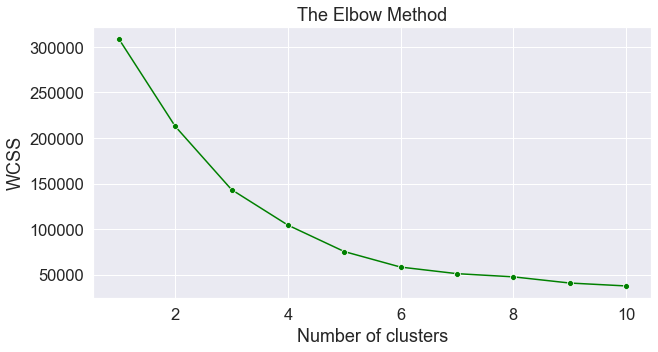

In [45]:
# to store WCSS
wcss = []

# for loop
for i in range(1, 11):
    # k-mean cluster model for different k values
    kmeans=KMeans(n_clusters=i,random_state = 0)
    kmeans.fit(df2_data)
    # inertia method returns wcss for that model
    wcss.append(kmeans.inertia_)
    
# figure size
plt.figure(figsize=(10,5))
sns.lineplot(range(1, 11), wcss,marker='o',color='green')

# labeling
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show();

On peut prendre K = 5 pour notre Kmean.

In [46]:
#Cluster K-means
model=KMeans(n_clusters=5,random_state = 42)
#adapter le modèle de données
model.fit(df2_data)
res_label = model.labels_
print(res_label)

KMeans(n_clusters=5, random_state=42)

[4 2 4 2 4 2 4 2 4 2 4 2 4 2 4 2 4 2 4 2 4 2 4 2 4 2 4 2 4 2 4 2 4 2 4 2 4
 2 4 2 4 2 4 2 4 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 3 0 3 1 3 0 3 0 3 0 3 0 3 0 3 0 3 0 3 1 3 0 3 0 3
 0 3 0 3 0 3 0 3 0 3 0 3 0 3 0 3 0 3 0 3 0 3 0 3 0 3 0 3 0 3 0 3 0 3 0 3 0
 3 0 3 0 3 0 3 0 3 0 3 0 3 0 3]


In [47]:
#On ajoute une colonne qui contiendra le cluster choisi par kmeans
df2.insert(0, "kmeansClass", model.labels_, True)

In [48]:
df2

,kmeansClass,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,4,1,Male,19,15,39
1,2,2,Male,21,15,81
2,4,3,Female,20,16,6
3,2,4,Female,23,16,77
4,4,5,Female,31,17,40
...,...,...,...,...,...,...
195,3,196,Female,35,120,79
196,0,197,Female,45,126,28
197,3,198,Male,32,126,74
198,0,199,Male,32,137,18


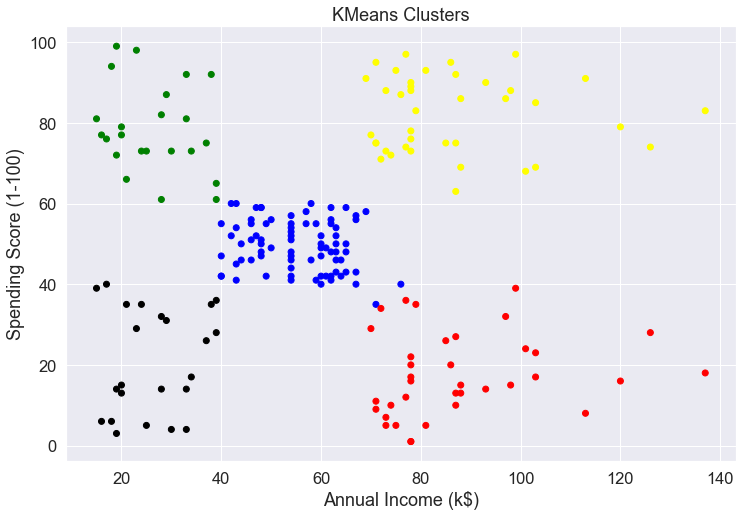

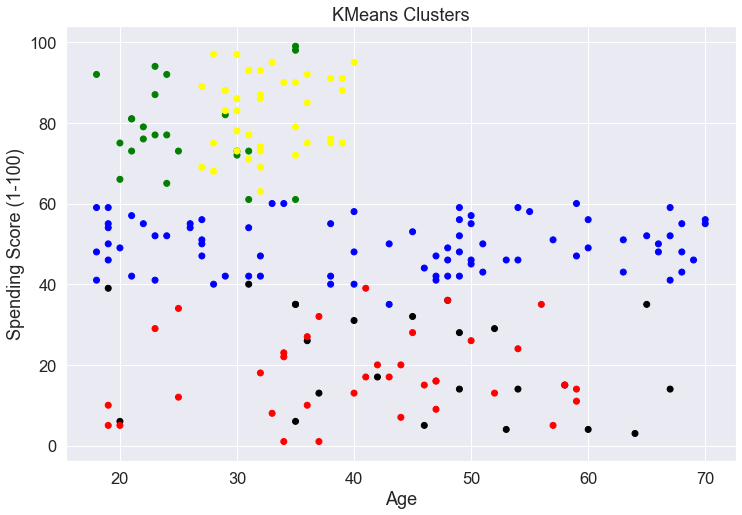

In [49]:
x1 = df2["Annual Income (k$)"]
x2 = df2["Age"]
y = df2["Spending Score (1-100)"]

colors = {0:'red', 1:'blue', 2:'green', 3:'yellow', 4:'black'}
colors_c = [colors[cl] for cl in df2["kmeansClass"]]

plt.scatter(x1, y, c=colors_c)
plt.title("KMeans Clusters")
plt.xlabel("Annual Income (k$)")
plt.ylabel("Spending Score (1-100)")
plt.show();

plt.scatter(x2, y, c=colors_c)
plt.title("KMeans Clusters")
plt.xlabel("Age")
plt.ylabel("Spending Score (1-100)")
plt.show();

$\textbf{Commentaire :}$

On peut classer les clusters en utilisant les 2 graphiques:

- Cluster vert: jeunes clients avec bas salaire mais forte dépense
- Cluster jaune: jeunes clients avec bon salaire et forte dépense
- Cluster rouge: clients de tout âge avec bon salaire mais faible dépense
- Cluster noir: clients de tout âge avec bas salaire et faible dépense
- Cluster bleu: clients de tout âge avec salaire moyen et dépense moyenne

In [50]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
pca = PCA()
pca.fit(df2_data)

PCA()

In [51]:
print(pca.explained_variance_)
print(pca.explained_variance_ratio_)

[700.26435482 684.33013636 167.22852389]
[0.45125272 0.44098465 0.10776263]


In [52]:
eig = pd.DataFrame(
{
"Dimension" : ["Dim" + str(x + 1) for x in range(3)],
"Variance expliquée" : pca.explained_variance_,
"% variance expliquée" : np.round(pca.explained_variance_ratio_ * 100),
"% cum. var. expliquée" : np.round(np.cumsum(pca.explained_variance_ratio_) * 100)
}
)
eig

,Dimension,Variance expliquée,% variance expliquée,% cum. var. expliquée
0,Dim1,700.264355,45.0,45.0
1,Dim2,684.330136,44.0,89.0
2,Dim3,167.228524,11.0,100.0


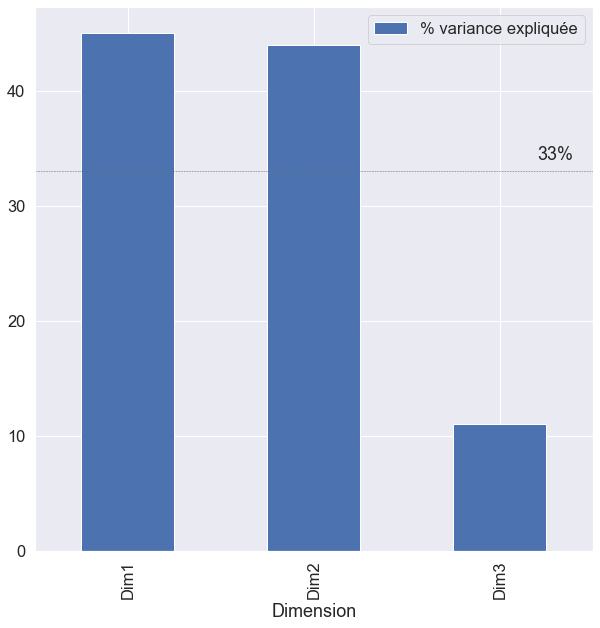

In [53]:
rcParams['figure.figsize'] =10, 10
eig.plot.bar(x = "Dimension", y = "% variance expliquée").text(2.2, 34, "33%") # ajout de texte
# permet un diagramme en barres
plt.axhline(y = 33, linewidth = .5, color = "dimgray", linestyle = "--") 
# ligne 33 = 100 / 3 (nb dimensions)
plt.show();

On remarque qu'avec 2 dimensions on arrive à expliquer 89 % de la variance des données.

In [54]:
df2_pca = pca.transform(df2_data)

In [55]:
df2_pca.shape

(200, 3)

In [56]:
df2.insert(0, "pca_dim1", df2_pca[:,0], True)
df2.insert(0, "pca_dim2", df2_pca[:,1], True)

In [57]:
df2_pca_df = pd.DataFrame({
"Dim1" : df2["pca_dim1"],
"Dim2" : df2["pca_dim2"],
"Spending Score (1-100)" : df2["Spending Score (1-100)"],
})
df2_pca_df

,Dim1,Dim2,Spending Score (1-100)
0,-31.870508,-33.001425,39
1,0.763397,-56.843865,81
2,-57.408726,-13.122936,6
3,-2.169896,-53.477905,77
4,-32.174920,-30.387005,40
...,...,...,...
195,58.353072,31.016926,79
196,19.909355,66.446425,28
197,58.521858,38.343853,74
198,20.981105,79.375146,18


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


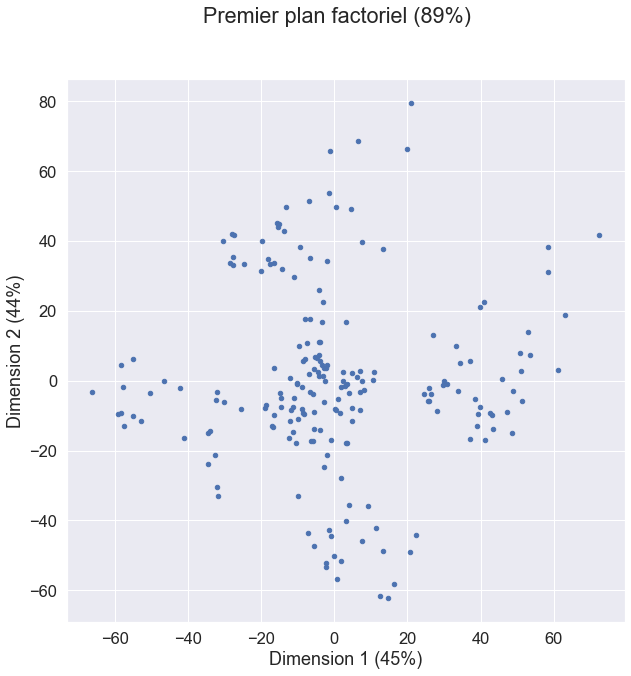

In [58]:
df2_pca_df.plot.scatter("Dim1", "Dim2") # nuage de points
plt.xlabel("Dimension 1 (45%)") # modification du nom de l'axe X
plt.ylabel("Dimension 2 (44%)") # idem pour axe Y
plt.suptitle("Premier plan factoriel (89%)") # titre général
plt.show();

Pour classer nos points on va rajouter une nouvelle colonne à notre dataset qui représentera les différents niveaux de dépenses.

In [59]:
def depense(spending_score):
    if spending_score < 33:
        return "Dépense Faible"
    elif spending_score >= 33 and spending_score <= 66:
        return "Dépense Moyenne"
    else:
        return "Dépense Elevé"

df2_pca_df['Dépense'] = df2_pca_df['Spending Score (1-100)'].apply(depense)

In [60]:
df2_pca_df

,Dim1,Dim2,Spending Score (1-100),Dépense
0,-31.870508,-33.001425,39,Dépense Moyenne
1,0.763397,-56.843865,81,Dépense Elevé
2,-57.408726,-13.122936,6,Dépense Faible
3,-2.169896,-53.477905,77,Dépense Elevé
4,-32.174920,-30.387005,40,Dépense Moyenne
...,...,...,...,...
195,58.353072,31.016926,79,Dépense Elevé
196,19.909355,66.446425,28,Dépense Faible
197,58.521858,38.343853,74,Dépense Elevé
198,20.981105,79.375146,18,Dépense Faible


In [61]:
# permet de créer une palette de couleurs, basée sur Color Brewer
palette = plt.get_cmap("Dark2")
couleurs = dict(zip(df2_pca_df["Dépense"].drop_duplicates(),palette(range(3))))
couleurs

{'Dépense Moyenne': array([0.10588235, 0.61960784, 0.46666667, 1.        ]),
 'Dépense Elevé': array([0.85098039, 0.37254902, 0.00784314, 1.        ]),
 'Dépense Faible': array([0.45882353, 0.43921569, 0.70196078, 1.        ])}

In [62]:
position = dict(zip(couleurs.keys(), range(3)))
position

{'Dépense Moyenne': 0, 'Dépense Elevé': 1, 'Dépense Faible': 2}

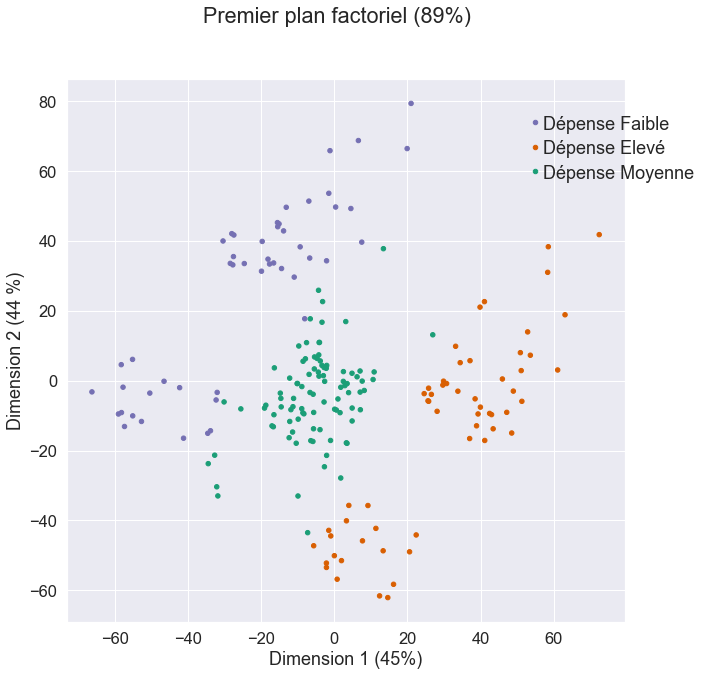

In [63]:
# Affichage des points avec une liste de couleurs
df2_pca_df.plot.scatter(x = "Dim1", y = "Dim2", c = [couleurs[p] for p in df2_pca_df["Dépense"]])
# boucle pour afficher la légende
for cont, coul in couleurs.items():
    plt.scatter(55, 7*position[cont]+60, c = [coul], s = 20)
    plt.text(57, 7*position[cont]-2 + 60, cont)
plt.xlabel("Dimension 1 (45%)")
plt.ylabel("Dimension 2 (44 %)")
plt.suptitle("Premier plan factoriel (89%)")
plt.show();


In [64]:
n = df2_data.shape[0] # nb individus
p = df2_data.shape[1] # nb variables
eigval = (n-1) / n * pca.explained_variance_ # valeurs propres
sqrt_eigval = np.sqrt(eigval) # racine carrée des valeurs propres
corvar = np.zeros((p,p)) # matrice vide pour avoir les coordonnées
for k in range(p):
    corvar[:,k] = pca.components_[k,:] * sqrt_eigval[k]
# on modifie pour avoir un dataframe
coordvar = pd.DataFrame({'id': df2_data.columns , 'COR_1': corvar[:,0], 'COR_2': corvar[:,1]})
coordvar

,id,COR_1,COR_2
0,Age,-4.988214,3.417435
1,Annual Income (k$),15.537927,21.093937
2,Spending Score (1-100),20.747375,-14.975829


L'axe 1 semble opposé les personnes en fonction de l'âge.

L'axe 2 semble opposé les personnes avec un faible revenu au personnes avec un fort revenu.